In [1]:
from google.colab import drive
drive.mount('/content/drive')
% cd drive/My Drive/hw3/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/hw3


In [0]:
import dataset
import ranking as rnk
import evaluate as evl
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import stats
from torch.utils.data import Dataset, TensorDataset, DataLoader
import itertools

import math
data = dataset.get_dataset().get_data_folds()[0]
data.read_data()


Testing learning_rate = 0.01, n_hidden = 150 and sigma = 0.01
"metric": "mean" ("standard deviation")
Epoch: 0, ndcg: 0.8276106488247384
Best parameters: {'learning_rate': 0.01, 'n_hidden': 150, 'epoch': 0, 'sigma': 0.01}
"metric": "mean" ("standard deviation")
Epoch: 1, ndcg: 0.8280026218282455
Best parameters: {'learning_rate': 0.01, 'n_hidden': 150, 'epoch': 1, 'sigma': 0.01}
"metric": "mean" ("standard deviation")
Epoch: 2, ndcg: 0.8311695075930169
Best parameters: {'learning_rate': 0.01, 'n_hidden': 150, 'epoch': 2, 'sigma': 0.01}
"metric": "mean" ("standard deviation")
Epoch: 3, ndcg: 0.8342248869872612
Best parameters: {'learning_rate': 0.01, 'n_hidden': 150, 'epoch': 3, 'sigma': 0.01}
"metric": "mean" ("standard deviation")
Epoch: 4, ndcg: 0.8342901329004079
Best parameters: {'learning_rate': 0.01, 'n_hidden': 150, 'epoch': 4, 'sigma': 0.01}
"metric": "mean" ("standard deviation")
Epoch: 5, ndcg: 0.835966077718572
Best parameters: {'learning_rate': 0.01, 'n_hidden': 150, 'epoc

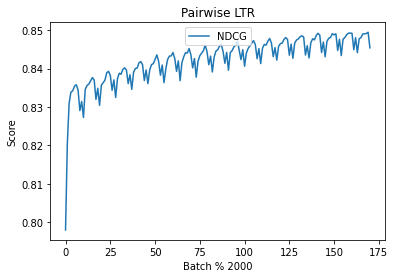

"metric": "mean" ("standard deviation")
ndcg and err on test set for lambdarank: (0.8457532822647057, 0.1382749235080951) (0.8240145376938337, 0.44426361582869334)


<Figure size 432x288 with 0 Axes>

In [7]:
# RankNet

class RankNet(torch.nn.Module):
    def __init__(self, n_feature, n_hidden):
        super(RankNet, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.output = torch.nn.Linear(n_hidden, 1)      
        
    def forward(self, x1):
        x = torch.nn.functional.relu(self.hidden(x1))
        x = self.output(x)
        
        return x

class Model():
    def __init__(self, n_feature, n_hidden, learning_rate, sigma):
        self.ranknet = RankNet(n_feature, n_hidden)
        self.optimizer = torch.optim.SGD(self.ranknet.parameters(), lr=learning_rate)

def eval_model(model, data_fold):
        x = torch.from_numpy(data_fold.feature_matrix).float()
        y = data_fold.label_vector
        model.ranknet.eval()
               
        output = model.ranknet(x)
        output = output.detach().cpu().numpy().squeeze()
        
        scores = evl.evaluate(data_fold, np.asarray(output))  

        return scores


def load_dataset():

    train_x = torch.from_numpy(data.train.feature_matrix).float()
    train_y = torch.from_numpy(data.train.label_vector).float()

    train_set = TensorDataset(train_x, train_y)
    train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)

    return train_loader
       

def plot_ndcg_loss(ndcgs):
    x = np.arange(len(ndcgs))
    fig, ax = plt.subplots()
    
    ax.plot(x, ndcgs, label='NDCG')
    ax.set_xlabel("Batch % 2000")
    ax.set_ylabel("Score")
    ax.set_title("Pairwise LTR")
    legend = ax.legend(loc='upper center')
    
    plt.show()
    plt.savefig('Pairwise_LTR_plot.png')

    
def get_distributions(model):
    data = dataset.get_dataset().get_data_folds()[0]
    data.read_data()
    model.ranknet.eval()

    val_x = torch.from_numpy(data.validation.feature_matrix).float()
    test_x = torch.from_numpy(data.test.feature_matrix).float()
           
    val = model.ranknet(val_x).detach().cpu().numpy().squeeze()
    test = model.ranknet(test_x).detach().cpu().numpy().squeeze()
    actual = np.concatenate((data.train.label_vector, data.validation.label_vector, data.test.label_vector))
    
    distributions = {
    "val_mean": np.mean(val),
    "val_std": np.std(val),
    "test_mean": np.mean(test),
    "test_std": np.std(test),
    "actual_mean": np.mean(actual), 
    "actual_std": np.std(actual),
    }
    
    return distributions


    
def train_batch(documentfeatures, labels, model, sig):
    for epoch in range(1):
      model.optimizer.zero_grad()

      output = model.ranknet(documentfeatures)
      
      loss = pairwiseloss(output, labels, sig)
  
      loss.backward()
      
      model.optimizer.step()
            
    return model
    
def pairwiseloss(predictedvals, values, sigma):
    
    predictedvals = predictedvals.squeeze()

    if values.shape[0] == 1:
        return (predictedvals - values)**2
        
    pairs = list(itertools.combinations(range(predictedvals.shape[0]), 2))
    val1, val2 = [x[0] for x in pairs], [x[1] for x in pairs]
   
    S = torch.sign(values[val1] - values[val2])
    s = predictedvals[val1] - predictedvals[val2]   
        
    C_T = 0.5 * (1 - S) * sigma * s + torch.log(1 + torch.exp(-sigma * s))
 
    return C_T.sum()


def train_best(best_params):
    epochs = best_params["epoch"]
    n_hidden = best_params["n_hidden"]
    learning_rate = best_params["learning_rate"]
    sigma = best_params["sigma"]
    
    model = Model(data.num_features, n_hidden, learning_rate, sigma)

    losses, ndcgs = [], []
    for epoch in range(epochs):
        eval_count = 0
        for qid in range(0, data.train.num_queries()):
            if data.train.query_size(qid) < 2:
                continue
            s_i, e_i = data.train.query_range(qid)
            
            documentfeatures = torch.tensor(data.train.feature_matrix[s_i:e_i]).float()
            labels = torch.tensor(data.train.label_vector[s_i:e_i])
            model = train_batch(documentfeatures, labels, model, sigma) 
            eval_count +=1
            if eval_count % 2000 == 0:
                scores = eval_model(model, data.validation)
                ndcgs.append(scores["ndcg"][0])
        print("Epoch: {}, ndcg: {}".format(epoch, scores["ndcg"][0]))
        
    return ndcgs, model

def hyperparam_search():
    # hyper-parameters
    epochs = 20
    learning_rates = [10**-2, 10**-1]
    n_hiddens = [150, 200, 250, 300, 350]
    sigmas = [10**-2, 10**-3]

    best_ndcg = 0
    for learning_rate in learning_rates:
        for n_hidden in n_hiddens:
            for sigma in sigmas:

                print("\nTesting learning_rate = {}, n_hidden = {} and sigma = {}".format(learning_rate, n_hidden, sigma))
                model = Model(data.num_features, n_hidden, learning_rate, sigma)

                last_ndcg = 0
                for epoch in range(epochs):

                    model.ranknet.train()
                    for qid in range(0, data.train.num_queries()):
                        if data.train.query_size(qid) < 2:
                            continue
                        s_i, e_i = data.train.query_range(qid)

                        documentfeatures = torch.tensor(data.train.feature_matrix[s_i:e_i]).float()
                        labels = torch.tensor(data.train.label_vector[s_i:e_i])

                        model = train_batch(documentfeatures, labels, model, sigma)  

                                       
                    scores = eval_model(model, data.validation)
              
                    ndcg = scores["ndcg"][0]
                    print("Epoch: {}, ndcg: {}".format(epoch, ndcg))
                            
                    if ndcg < last_ndcg:
                        break
                    last_ndcg = ndcg
                    if ndcg > best_ndcg:
                        best_ndcg = ndcg
                        best_params = {"learning_rate": learning_rate, "n_hidden": n_hidden, "epoch": epoch, "sigma": sigma}            
                        print("Best parameters:", best_params)
    
    return best_params
  

if __name__ == "__main__":
    #determine best hyper parameters
    best_params = hyperparam_search()
    #train best model
    ndcgs, model = train_best(best_params)
    #plot ndcg     
    plot_ndcg_loss(ndcgs)
    #get distributions of scores
    distributions = get_distributions(model)
    #performance on test set
    data = dataset.get_dataset().get_data_folds()[0]
    data.read_data()
    scores = eval_model(model, data.test)
    print('ndcg and err on test set for lambdarank:', scores['ndcg'], scores['err'])




Testing learning_rate = 0.01, n_hidden = 150 and sigma = 0.1
"metric": "mean" ("standard deviation")
Epoch: 0, ndcg: 0.7966549432292663
Best parameters: {'learning_rate': 0.01, 'n_hidden': 150, 'epoch': 0, 'sigma': 0.1}
"metric": "mean" ("standard deviation")
Epoch: 1, ndcg: 0.7988986020630331
Best parameters: {'learning_rate': 0.01, 'n_hidden': 150, 'epoch': 1, 'sigma': 0.1}
"metric": "mean" ("standard deviation")
Epoch: 2, ndcg: 0.7919130103993255

Testing learning_rate = 0.01, n_hidden = 150 and sigma = 0.01
"metric": "mean" ("standard deviation")
Epoch: 0, ndcg: 0.8277890991412958
Best parameters: {'learning_rate': 0.01, 'n_hidden': 150, 'epoch': 0, 'sigma': 0.01}
"metric": "mean" ("standard deviation")
Epoch: 1, ndcg: 0.8298203013342604
Best parameters: {'learning_rate': 0.01, 'n_hidden': 150, 'epoch': 1, 'sigma': 0.01}
"metric": "mean" ("standard deviation")
Epoch: 2, ndcg: 0.831739055357635
Best parameters: {'learning_rate': 0.01, 'n_hidden': 150, 'epoch': 2, 'sigma': 0.01}
"me

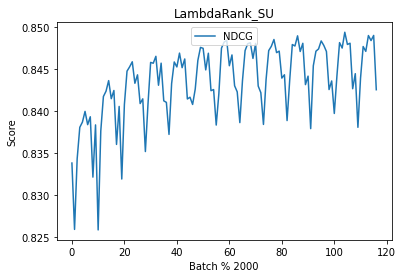

<Figure size 432x288 with 0 Axes>

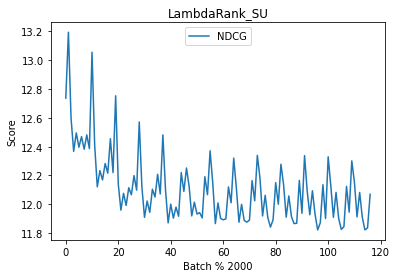

"metric": "mean" ("standard deviation")
ndcg and err on test set for lambdarank Sped Up: (0.8395545601409525, 0.13975811442533623) (0.8278341838380344, 0.4394107831566936)


<Figure size 432x288 with 0 Axes>

In [3]:
# Sped Up RankNet

class RankNetSU(torch.nn.Module):
    def __init__(self, n_feature, n_hidden):
        super(RankNetSU, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.output = torch.nn.Linear(n_hidden, 1)      
        
    def forward(self, x1):
        x = torch.nn.functional.relu(self.hidden(x1))
        x = self.output(x)
        
        return x

class Model():
    def __init__(self, n_feature, n_hidden, learning_rate, sigma):
        self.ranknet = RankNetSU(n_feature, n_hidden)
        self.optimizer = torch.optim.SGD(self.ranknet.parameters(), lr=learning_rate)

def eval_model(model, data_fold):
        x = torch.from_numpy(data_fold.feature_matrix).float()
        y = data_fold.label_vector
        model.ranknet.eval()
               
        output = model.ranknet(x)
        output = output.detach().cpu().numpy().squeeze()
        
        scores = evl.evaluate(data_fold, np.asarray(output))  

        return scores


def load_dataset():

    train_x = torch.from_numpy(data.train.feature_matrix).float()
    train_y = torch.from_numpy(data.train.label_vector).float()

    train_set = TensorDataset(train_x, train_y)
    train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)

    return train_loader
       

def plot_ndcg_loss(ndcgs):
    x = np.arange(len(ndcgs))
    fig, ax = plt.subplots()
    
    ax.plot(x, ndcgs, label='NDCG')
    ax.set_xlabel("Batch % 2000")
    ax.set_ylabel("Score")
    ax.set_title("LambdaRank_SU")
    legend = ax.legend(loc='upper center')
    
    plt.show()
    plt.savefig('LambdaRank_SU_ndcg_plot.png')

def plot_arrs_loss(arrs):
    x = np.arange(len(arrs))
    fig, ax = plt.subplots()
    
    ax.plot(x, arrs, label='ARR')
    ax.set_xlabel("Batch % 2000")
    ax.set_ylabel("Score")
    ax.set_title("LambdaRank_SU")
    legend = ax.legend(loc='upper center')
    
    plt.show()
    plt.savefig('LambdaRank_SU_arrs_plot.png')


    
def train_batch(documentfeatures, labels, model, sig):
    for epoch in range(1):

            model.optimizer.zero_grad()

            output = model.ranknet(documentfeatures)
            
            loss = pairwiseloss(output, labels, sig)
                        
            loss.sum().backward()
            
            model.optimizer.step()

    return model
    

def pairwiseloss(preds, labels, sigma):
    preds = preds.squeeze()    
    
    np.set_printoptions(linewidth=250)
    
    pairs = list(itertools.combinations(range(preds.shape[0]), 2))
    idx1, idx2 = [pair[0] for pair in pairs], [pair[1] for pair in pairs]
   
    S = torch.sign(labels[idx1] - labels[idx2])
    s = preds[idx1] - preds[idx2] 

    lambda_ij = sigma * (0.5 * (1 - S) - (1 / (1 + torch.exp(sigma * s))))
    
    lambda_i = torch.zeros((preds.shape[0], preds.shape[0]))
    lambda_i[np.triu_indices(preds.shape[0], k=1)] = lambda_ij
    lambda_i = (lambda_i - lambda_i.T).sum(1)
    
    return preds * lambda_i.detach()


def hyperparam_search():
    # hyper-parameters
    epochs = 20
    learning_rates = [10**-2, 10**-1]
    n_hiddens = [150, 200, 250, 300, 350]
    sigmas = [10**-1, 10**-2, 10**-3]

    best_ndcg = 0
    for learning_rate in learning_rates:
        for n_hidden in n_hiddens:
            for sig in sigmas:
        
                print("\nTesting learning_rate = {}, n_hidden = {} and sigma = {}".format(learning_rate, n_hidden, sig))
                model = Model(data.num_features, n_hidden, learning_rate, sig)

                last_ndcg = 0
                for epoch in range(epochs):

                    model.ranknet.train()
                    for qid in range(0, data.train.num_queries()):
                        if data.train.query_size(qid) < 2:
                            continue
                        s_i, e_i = data.train.query_range(qid)

                        documentfeatures = torch.tensor(data.train.feature_matrix[s_i:e_i]).float()
                        labels = torch.tensor(data.train.label_vector[s_i:e_i])

                        model = train_batch(documentfeatures, labels, model, sig)  


                    scores = eval_model(model, data.validation)

                    ndcg = scores["ndcg"][0]
                    print("Epoch: {}, ndcg: {}".format(epoch, ndcg))

                    if ndcg < last_ndcg:
                        break
                    last_ndcg = ndcg
                    if ndcg > best_ndcg:
                        best_ndcg = ndcg
                        best_params = {"learning_rate": learning_rate, "n_hidden": n_hidden, "epoch": epoch, "sigma": sig}            
                        print("Best parameters:", best_params)
    
    return best_params


def train_best(best_params):
    epochs = best_params["epoch"]
    n_hidden = best_params["n_hidden"]
    learning_rate = best_params["learning_rate"]
    sigma = best_params["sigma"]
    
    model = Model(data.num_features, n_hidden, learning_rate, sigma)

    losses, ndcgs, arrs = [], [], []
    for epoch in range(epochs):
        eval_count = 0
        for qid in range(0, data.train.num_queries()):
            if data.train.query_size(qid) < 2:
                continue
            s_i, e_i = data.train.query_range(qid)
            
            documentfeatures = torch.tensor(data.train.feature_matrix[s_i:e_i]).float()
            labels = torch.tensor(data.train.label_vector[s_i:e_i])
            model = train_batch(documentfeatures, labels, model, sigma) 
            eval_count +=1
            if eval_count % 2000 == 0:
                scores = eval_model(model, data.validation)
                ndcgs.append(scores["ndcg"][0])
                arrs.append(scores['relevant rank'][0])
        print("Epoch: {}, ndcg: {}, ARR: {}".format(epoch, scores["ndcg"][0], scores['relevant rank'][0]))
        
    return ndcgs, arrs, model

def get_distributions(model):
    data = dataset.get_dataset().get_data_folds()[0]
    data.read_data()
    model.ranknet.eval()

    val_x = torch.from_numpy(data.validation.feature_matrix).float()
    test_x = torch.from_numpy(data.test.feature_matrix).float()
           
    val = model.ranknet(val_x).detach().cpu().numpy().squeeze()
    test = model.ranknet(test_x).detach().cpu().numpy().squeeze()
    actual = np.concatenate((data.train.label_vector, data.validation.label_vector, data.test.label_vector))
    
    distributions = {
    "val_mean": np.mean(val),
    "val_std": np.std(val),
    "test_mean": np.mean(test),
    "test_std": np.std(test),
    "actual_mean": np.mean(actual), 
    "actual_std": np.std(actual),
    }
    
    return distributions



if __name__ == "__main__":
    #determine best hyper parameters
    best_params = hyperparam_search()
    # print(best_params)
    #train best model
    ndcgs, arrs, model = train_best(best_params)
    #plot ndcg   
    plot_ndcg_loss(ndcgs)
    #plot arrs   
    plot_ndcg_loss(arrs)
    #get distributions of scores
    distributions = get_distributions(model)
    #performance on test set
    data = dataset.get_dataset().get_data_folds()[0]
    data.read_data()
    scores = eval_model(model, data.test)
    print('ndcg and err on test set for lambdarank Sped Up:', scores['ndcg'], scores['err'])